# $\bm{8}$ $\enspace$ **线性回归**

### $\bm{8.2}$ $\enspace$ **线性回归的从零开始实现**

我们将从零开始整个方法，包括数据流水线、模型、损失函数和小批量随机梯度下降优化器

In [18]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

根据带有噪声的线性模型构造一个人造数据集。 我们使用线性模型参数 $\bm{w} = [2, −3.4]^T$、$b = 4.2$ 和噪声项 $\epsilon$ 生成数据集及其标签：
$$
    \bm{y}=\bm{Xw}+b+\epsilon
$$

In [19]:
def synthetic_data(w, b, num_examples):
    """生成 y = Xw + b + epsilon"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))


true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

`features` 中的每一行都包含一个二维数据样本，`labels` 中的每一行都包含一维标签值（一个标量）

In [20]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([-1.7577,  0.4919]) 
label: tensor([-0.9909])


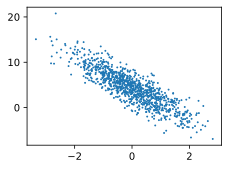

In [21]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1)

定义一个 `data_iter` 函数， 该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为 `batch_size` 的小批量

In [22]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 1.2353, -0.0495],
        [-0.5678,  0.7221],
        [-0.1090, -0.6323],
        [ 0.8993, -1.9957],
        [ 1.2594,  0.7339],
        [-1.1664,  1.3123],
        [ 0.1443,  0.2479],
        [ 1.1733, -1.5111],
        [-0.9413,  0.3783],
        [ 0.1694, -0.4166]]) 
 tensor([[ 6.8349],
        [ 0.6177],
        [ 6.1358],
        [12.7845],
        [ 4.2144],
        [-2.5893],
        [ 3.6311],
        [11.6935],
        [ 1.0465],
        [ 5.9578]])


定义初始化模型参数

In [23]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

定义模型

In [24]:
def linreg(X, w, b):  
    """线性回归模型"""
    return torch.matmul(X, w) + b

定义损失函数

In [25]:
def squared_loss(y_hat, y):  
    """均方损失。"""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

定义优化算法

In [26]:
def sgd(params, lr, batch_size):  
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

训练过程

In [27]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.031874
epoch 2, loss 0.000110
epoch 3, loss 0.000048


比较真实参数和通过训练学到的参数来评估训练的成功程度

In [28]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([0.0002, 0.0006], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0009], grad_fn=<RsubBackward1>)
